Start here to begin with Stingray.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Introduction

`StingrayTimeseries` is a generic time series object, and also acts as the base class for Stingray's `Lightcurve` and `EventList`. It is a data container that associate times with measurements.
The only compulsory element in such a series is indeed the `time` attribute.

Many of the methods in `Lightcurve` and `EventList`, indeed, are implemented in this class. For example, methods that truncate, add, subtract the series, or that filter it in some way (e.g. by adding a mask or applying the good time intervals)


### Internal Class structure

For most of this internal behavior, all turns around the concept of "Array attributes", "Internal attributes", "Meta attributes", and "Not array attributes". 

**Array attributes** Ideally, if one were to create a new object based on a table format, array attributes would be the table columns (so, they all have the same length of the `time` column).
Example array attributes are

+ `counts`, the number of counts in each bin of a typical X-ray light curve;
+ `dt`, the sampling time, *if data are not evenly sampled*;

Note that array attributes can have any dimension. The only important thing is that the *first dimension's size* is equal to the size of `time`. E.g. if time is `[1, 2, 3]` (shape (3,) ), an array attribute could be `[[4, 4], [2, 3], [4, 5]]` (shape (3, 2)), but not `[[1, 2, 3]]` (shape (1, 3))

**Meta attributes** The most useful attributes are probably 

+ `gti`, or the Good Time Intervals where measurements are supposed to be reliable; 
+ `dt`, the sampling time, when *constant* (evenly sampled time series);
+ `mjdref` the reference MJD for all the time measurements in the series

**Internal array attributes** Some classes, like `Lightcurve`, expose attributes (such as `counts`, `counts_err`) that are not arrays but properties. This is done for a flexible manipulation of counts, count rates etc, that can be set asynchronously depending on which one was set first (see the `Lightcurve` documentation). The actual arrays containing data are internal attributes (such as `_counts`) that get set only if needed. Another thing that lightcurve does is throwing an error if one wants to set the time to a different length than its array attributes. The actual time is stored in the `_time` attribute, and this check is done when one tries to modify the time through the `time` property (by setting `lc.time`).

**Not array attributes** Some quantities, such as GTI, might in principle have the same length of `time`. One can then add `gti` to the list of `not_array_attributes`, that protects from the hypothesis of considering `gti` a standard array attribute.

## Creating a time series

In [2]:
from stingray import StingrayTimeseries

A `StingrayTimeseries` object is usually created in one of the following two ways:

1. From an array of time stamps and an array of any name.
        
        ts = StingrayTimeseries(times, array_attrs=dict(my_array_attr=my_attr), **opts)

    where `**opts` are any (optional) keyword arguments (e.g. `dt=0.1`, `mjdref=55000`, etc.)
    In principle, array attributes can be specified as simple keyword arguments. But when we use the `array_attrs` keyword, we will run a check on the length of the arrays, and raise an error if they are not of a shape compatible with the ``time`` array.

2. A binned `StingrayTimeseries`, a generalization of a uniformly sampled light curve, can be obtained from an EventList object, through the `to_binned_timeseries` method.

        ev = EventList(times, mjdref=55000)
        ev.my_attr = my_attr_array
        ts = ev.to_binned_timeseries(ev, dt=1, array_attrs={"my_attr": my_attr}, **opts)

as will be described in the next sections.

An additional possibility is creating an empty `StingrayTimeseries` object, whose attributes will be filled in later:

    ts = StingrayTimeseries()

or, if one wants to specify any keyword arguments:

    ts = StingrayTimeseries(**opts)

 This option is usually only relevant to advanced users, but we mention it here for reference

### 1. Array of time stamps and counts

Create 1000 time stamps

In [3]:
times = np.arange(1000)
times[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Create 1000 random Poisson-distributed counts:

In [4]:
my_attr = np.random.normal(size=len(times))
my_attr[:10]

array([ 0.95763206, -0.68140959,  0.79078141,  2.62611237,  0.11719473,
       -0.06181397, -0.16788101,  1.40577403,  1.21971114, -1.23762776])

Create a Lightcurve object with the times and counts array.

In [5]:
ts = StingrayTimeseries(times, array_attrs={"my_attr": my_attr})

The number of data points can be counted with the `len` function, or through the `n` property.

In [6]:
len(ts), ts.n

(1000, 1000)

### 2. From an event list

Often, you might have an event list with associated properties such as weight, polarization, etc. If this is the case, you can use the `to_binned_timeseries` method of `EventList` to turn these photon arrival times into a regularly binned timeseries.

In [7]:
from stingray import EventList

arrival_times = np.sort(np.random.uniform(0, 100, 1000))
goofy = np.random.normal(size=arrival_times.size)
mickey = np.random.chisquare(2, size=arrival_times.size)
ev = EventList(arrival_times, gti=[[0, 100]])
ev.goofy = goofy
ev.mickey = mickey

To create the time series, it's necessary to specify the sampling time `dt`. By default, the time series will create histograms with all the array attributes of `EventLists` with the same length as `ev.time`.

In [8]:
ts_new = ev.to_binned_timeseries(dt=1)

One can specify which attributes to use through the `array_attrs` keyword

In [9]:
ts_new_small = ev.to_binned_timeseries(dt=1, array_attrs=["goofy"])

All attributes that have been histogrammed can be accessed through the `array_attrs` method:

In [10]:
ts_new.array_attrs()

['counts', 'goofy', 'mickey']

In [11]:
ts_new_small.array_attrs()

['counts', 'goofy']

Note the `counts` attribute, which is always created by the `to_binned_timeseries` method and gives the number of photons which concurred to creating each value of the time series.

The time bins can be seen with the `.time` attribute

In [12]:
ts_new.time

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
       33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
       44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
       55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5,
       66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5,
       77.5, 78.5, 79.5, 80.5, 81.5, 82.5, 83.5, 84.5, 85.5, 86.5, 87.5,
       88.5, 89.5, 90.5, 91.5, 92.5, 93.5, 94.5, 95.5, 96.5, 97.5, 98.5,
       99.5])

## Good Time Intervals

`StingrayTimeseries` (and most other core `stingray` classes) support the use of *Good Time Intervals* (or GTIs), which denote the parts of an observation that are reliable for scientific purposes. Often, GTIs introduce gaps (e.g. where the instrument was off, or affected by solar flares). By default. GTIs are passed and don't apply to the data within a `StingrayTimeseries` object, but become relevant in a number of circumstances, such as when generating `Powerspectrum` objects. 

If no GTIs are given at instantiation of the `StingrayTimeseries` class, an artificial GTI will be created spanning the entire length of the data set being passed in, including half a sample time before and after:

In [13]:
times = np.arange(1000)
counts = np.random.poisson(100, size=len(times))

ts = StingrayTimeseries(times, array_attrs={"counts":counts}, dt=1)

In [14]:
ts.gti

array([[-5.000e-01,  9.995e+02]])

In [15]:
ts.counts

array([105, 102, 120,  88,  85, 104,  98,  97,  86, 105, 101,  90, 113,
       107, 105, 112,  91, 101,  99,  91, 113,  93, 108,  89,  97, 114,
       101,  90, 109,  85, 117,  98, 103,  98, 100, 101,  85,  94,  79,
       107, 118, 104,  98,  98,  97, 106, 103,  93, 104, 101, 117, 102,
       116,  96,  95, 102, 104,  92, 113, 104, 101, 127, 111,  87, 125,
       107, 112,  93,  94,  98,  89, 110,  98,  95,  98,  92, 109, 115,
        99,  88,  95,  98,  92,  86,  81,  93,  92, 108, 103,  91, 105,
       101,  90, 114,  95,  92,  91,  85, 100,  93, 106,  95,  90, 104,
        97,  94,  98,  95, 109,  94, 115,  99, 101, 111, 111, 103, 107,
        87,  95,  94, 106,  87,  64, 115, 100,  95,  93,  87,  92, 107,
       107,  98,  96,  88,  84,  81, 110,  81,  89, 109, 114,  87, 101,
       102, 107, 117,  92, 109,  87, 100,  97,  99,  92,  96, 101, 102,
       112, 101, 116, 105,  98,  85, 102,  93,  77,  95, 103,  98, 102,
       100,  78,  74, 104, 103,  99,  86, 111, 115,  92, 101,  9

In [16]:
print(times[0]) # first time stamp in the light curve
print(times[-1]) # last time stamp in the light curve
print(ts.gti) # the GTIs generated within Lightcurve

0
999
[[-5.000e-01  9.995e+02]]


In [17]:
gti = [(0, 500), (600, 1000)]

In [18]:
ts = StingrayTimeseries(times, array_attrs={"counts":counts}, gti=gti)

In [19]:
print(ts.gti)

[[   0  500]
 [ 600 1000]]


We'll get back to these when we talk more about some of the methods that apply GTIs to the data.


## Combining StingrayTimeseries objects

A `StingrayTimeseries` object can be combined with others in various ways. The best way is using the `join` operation, that combines the data according to the strategy defined by the user.

The default strategy is `infer`. Similar to what can be seen in `EventLists`, it decides what to do depending on the fact that GTIs have overlaps or not. If there are overlaps, GTIs are intersected. Otherwise, they are appended and merged. But one can select between:

+ "intersection", the GTIs are merged using the intersection of the GTIs. 
+ "union", the GTIs are merged using the union of the GTIs. 
+ "append", the GTIs are simply appended but *they must be mutually exclusive* (have no overlaps).
+ "none", a single GTI with the minimum and the maximum time stamps of all GTIs is returned. 

The data are always all merged. No filtering is applied for the new GTIs. But the user can always use the `apply_gtis` method to filter them out later.

In [20]:
ts = StingrayTimeseries(
    time=[1, 2, 3], 
    gti=[[0.5, 3.5]], 
    array_attrs={"blah": [1, 1, 1]},
)
ts_other = StingrayTimeseries(
    time=[1.1, 2.1, 4, 5, 6.5], 
    array_attrs={"blah": [2, 2, 2, 2, 2]}, 
    gti=[[1.5, 2.5], [4.5, 7.5]],
)

ts_new = ts.join(ts_other, strategy="union")

for attr in ["gti", "time", "blah"]:
    print(f"New {attr}:", getattr(ts_new, attr))


New gti: [[0.5 3.5]
 [4.5 7.5]]
New time: [1.  1.1 2.  2.1 3.  4.  5.  6.5]
New blah: [1 2 1 2 1 2 2 2]


In [21]:
ts_new = ts.join(ts_other, strategy="intersect")

for attr in ["gti", "time", "blah"]:
    print(f"New {attr}:", getattr(ts_new, attr))


New gti: [[0.5 3.5]]
New time: [1.  1.1 2.  2.1 3.  4.  5.  6.5]
New blah: [1 2 1 2 1 2 2 2]


In [22]:
ts_new = ts.join(ts_other, strategy="none")

for attr in ["gti", "time", "blah"]:
    print(f"New {attr}:", getattr(ts_new, attr))


New gti: [[1.  6.5]]
New time: [1.  1.1 2.  2.1 3.  4.  5.  6.5]
New blah: [1 2 1 2 1 2 2 2]


In this case, `append` will fail, because the GTIs intersect.

In [23]:
ts_new = ts.join(ts_other, strategy="append")


ValueError: In order to append, GTIs must be mutually exclusive.

Empty `StingrayTimeseries` will throw warnings but try to be accommodating

In [24]:
StingrayTimeseries().join(StingrayTimeseries()).time is None

True

In [25]:
ts = StingrayTimeseries(time=[1, 2, 3])
ts_other = StingrayTimeseries()
ts_new = ts.join(ts_other)
ts_new.time


array([1, 2, 3])

When the data being merged have a different time resolution (e.g. unevenly sampled data, events from instruments with different frame times), the time resolution becomes an array attribute:

In [26]:
ts = StingrayTimeseries(time=[10, 20, 30], dt=1)
ts_other = StingrayTimeseries(time=[40, 50, 60], dt=3)
ts_new = ts.join(ts_other, strategy="union")

ts_new.dt


array([1, 1, 1, 3, 3, 3])

In all other cases, meta attributes are simply transformed into a comma-separated list (if strings) or tuples

In [27]:
ts = StingrayTimeseries(time=[10, 20, 30], a=1, b="a")
ts_other = StingrayTimeseries(time=[40, 50, 60], a=3, b="b")
ts_new = ts.join(ts_other, strategy="union")

ts_new.a, ts_new.b

((1, 3), 'a,b')

Array attributes that are only in one series will receive `nan` values in the data corresponding to the other series

In [28]:
ts = StingrayTimeseries(time=[1, 2, 3], blah=[3, 3, 3])
ts_other = StingrayTimeseries(time=[4, 5])
ts_new = ts.join(ts_other, strategy="union")

ts_new.blah


array([ 3.,  3.,  3., nan, nan])

When using `strategy="infer"`, the intersection or the union will be used depending on the fact that GTI overlap or not

In [29]:
ts = StingrayTimeseries(time=[1, 2, 3], blah=[3, 3, 3], gti=[[0.5, 3.5]])
ts1 = StingrayTimeseries(time=[5, 6], gti=[[4.5, 6.5]])
ts2 = StingrayTimeseries(time=[2.1, 2.9], blah=[4, 4], gti=[[1.5, 3.5]])
ts_new_1 = ts.join(ts1, strategy="infer")
ts_new_2 = ts.join(ts2, strategy="infer")

ts_new_1.blah, ts_new_2.blah


(array([ 3.,  3.,  3., nan, nan]), array([3, 3, 4, 4, 3]))

## Operations

### Addition/Subtraction

Two time series can be summed up or subtracted from each other **if they have same time arrays.**

In [30]:
ts = StingrayTimeseries(times, array_attrs={"blabla":counts}, dt=1, skip_checks=True)
ts_rand = StingrayTimeseries(times, array_attrs={"blabla": [600]*1000}, dt=1, skip_checks=True)

In [31]:
ts_sum = ts + ts_rand

In [32]:
print("Counts in light curve 1: " + str(ts.blabla[:5]))
print("Counts in light curve 2: " + str(ts_rand.blabla[:5]))
print("Counts in summed light curve: " + str(ts_sum.blabla[:5]))

Counts in light curve 1: [105 102 120  88  85]
Counts in light curve 2: [600 600 600 600 600]
Counts in summed light curve: [705 702 720 688 685]


### Negation

A negation operation on the time series object inverts the count array from positive to negative values.

In [33]:
ts_neg = -ts

In [34]:
ts_sum = ts + ts_neg

In [35]:
np.all(ts_sum.blabla == 0)  # All the points on ts and ts_neg cancel each other

True

### Indexing

Count value at a particular time can be obtained using indexing.

In [36]:
ts[120]

In [37]:
ts[120].time, ts[120].blabla, ts.time[120], ts.blabla[120]

(array([120]), array([106]), 120, 106)

A Lightcurve can also be sliced to generate a new object.

In [38]:
ts_sliced = ts[100:200]

In [39]:
len(ts_sliced.blabla)

100

## Other useful Methods

Two time series can be combined into a single object using the `concatenate` method. Note that both of them must not have overlapping time arrays.

In [40]:
ts_1 = ts
ts_2 = StingrayTimeseries(np.arange(1000, 2000), array_attrs={"blabla": np.random.rand(1000)*1000}, dt=1, skip_checks=True)
ts_long = ts_1.concatenate(ts_2)

The method will fail if the time series have overlaps:

In [41]:
ts_1.concatenate(StingrayTimeseries(np.arange(800, 1000), gti=[[800, 1000]]))

ValueError: In order to append, GTIs must be mutually exclusive.

### Truncation

A light curve can also be truncated.

In [42]:
ts_cut = ts_long.truncate(start=0, stop=1000)

In [43]:
len(ts_cut)

1000

**Note** : By default, the `start` and `stop` parameters are assumed to be given as **indices** of the time array. However, the `start` and `stop` values can also be given as time values in the same value as the time array.

In [44]:
ts_cut = ts_long.truncate(start=500, stop=1500, method='time')

In [45]:
ts_cut.time[0], ts_cut.time[-1]

(500, 1499)

### Re-binning

The time resolution (`dt`) can also be changed to a larger value.

**Note** : While the new resolution need not be an integer multiple of the previous time resolution, be aware that if it is not, the last bin will be cut off by the fraction left over by the integer division.

In [46]:
ts_rebinned = ts_long.rebin(2)

In [47]:
print("Old time resolution = " + str(ts_long.dt))
print("Number of data points = " + str(ts_long.n))
print("New time resolution = " + str(ts_rebinned.dt))
print("Number of data points = " + str(ts_rebinned.n))

Old time resolution = 1
Number of data points = 2000
New time resolution = 2
Number of data points = 1000


### Sorting

A time series can be sorted using the `sort` method. This function sorts `time` array and the `counts` array is changed accordingly.

In [48]:
new_ts = StingrayTimeseries(time=[2, 1, 3], array_attrs={"blabla": [200, 100, 300]}, dt=1)

In [49]:
new_ts_sort = new_ts.sort(reverse=True)

In [50]:
new_ts_sort.time, new_ts_sort.blabla

(array([3, 2, 1]), array([300, 200, 100]))

### Plotting

A curve can be plotted with the `plot` method. Time intervals outside GTIs will be plotted as vertical red bands. 

<Axes: xlabel='Time (s)', ylabel='blabla'>

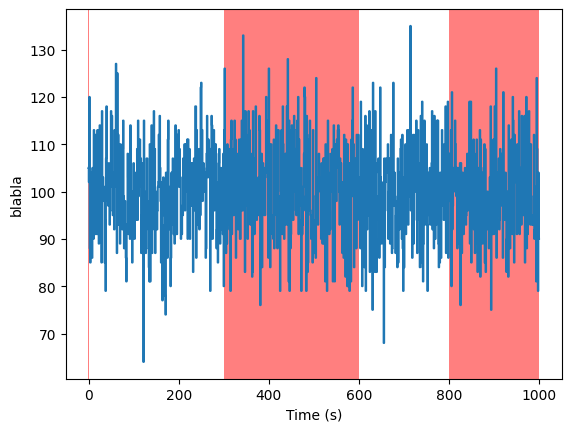

In [51]:
ts.gti = np.asarray([[1, 300], [600, 800]])
ts.plot("blabla")

If a given array attr has an error bar (indicated by the attribute name + `_err`), one can specify `witherrors=True` to plot the attribute.

<Axes: xlabel='Time (s)', ylabel='blabla (cts)'>

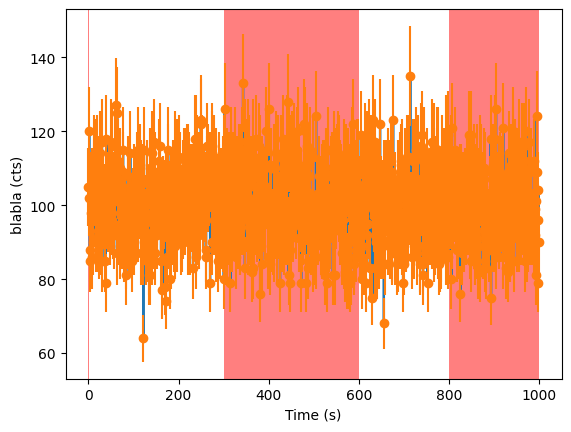

In [57]:
ts.blabla_err = ts.blabla / 10.
ts.plot("blabla", labels=["Time (s)", "blabla (cts)"], witherrors=True)

A plot can also be customized using several keyword arguments.

In [58]:
help(ts.plot)

Help on method plot in module stingray.base:

plot(attr, witherrors=False, labels=None, ax=None, title=None, marker='-', save=False, filename=None, plot_btis=True, axis_limits=None) method of stingray.base.StingrayTimeseries instance
    Plot the time series using ``matplotlib``.

    Plot the time series object on a graph ``self.time`` on x-axis and
    ``self.counts`` on y-axis with ``self.counts_err`` optionally
    as error bars.

    Parameters
    ----------
    attr: str
        Attribute to plot.

    Other parameters
    ----------------
    witherrors: boolean, default False
        Whether to plot the StingrayTimeseries with errorbars or not
    labels : iterable, default ``None``
        A list or tuple with ``xlabel`` and ``ylabel`` as strings. E.g.
        if the attribute is ``'counts'``, the list of labels
        could be ``['Time (s)', 'Counts (s^-1)']``
    ax : ``matplotlib.pyplot.axis`` object
        Axis to be used for plotting. Defaults to creating a new one.
  

The figure drawn can also be saved in a file using keywords arguments in the plot method itself.

<Axes: xlabel='Time (s)', ylabel='blabla'>

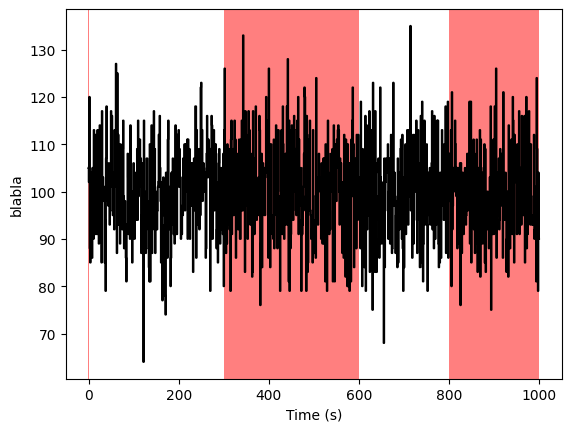

In [59]:
ts.plot("blabla", marker = 'k', save=True, filename="lightcurve.png")

### MJDREF and Shifting Times

The `mjdref` keyword argument defines a reference time in Modified Julian Date. Often, X-ray missions count their internal time in seconds from a given reference date and time (so that numbers don't become arbitrarily large). The data is then in the format of Mission Elapsed Time (MET), or seconds since that reference time. 

`mjdref` is generally passed into the `Lightcurve` object at instantiation, but it can be changed later:

In [60]:
mjdref = 91254
time = np.arange(1000)
counts = np.random.poisson(100, size=len(time))

ts = StingrayTimeseries(time, array_attrs={"counts": counts}, dt=1, skip_checks=True, mjdref=mjdref)
print(ts.mjdref)

91254


In [61]:
mjdref_new = mjdref - 20 / 86400  # Subtract 20 seconds from MJDREF
ts_new = ts.change_mjdref(mjdref_new)
print(ts_new.mjdref)

91253.99976851852


In [62]:
ts_new.time

array([  19.99999965,   20.99999965,   21.99999965,   22.99999965,
         23.99999965,   24.99999965,   25.99999965,   26.99999965,
         27.99999965,   28.99999965,   29.99999965,   30.99999965,
         31.99999965,   32.99999965,   33.99999965,   34.99999965,
         35.99999965,   36.99999965,   37.99999965,   38.99999965,
         39.99999965,   40.99999965,   41.99999965,   42.99999965,
         43.99999965,   44.99999965,   45.99999965,   46.99999965,
         47.99999965,   48.99999965,   49.99999965,   50.99999965,
         51.99999965,   52.99999965,   53.99999965,   54.99999965,
         55.99999965,   56.99999965,   57.99999965,   58.99999965,
         59.99999965,   60.99999965,   61.99999965,   62.99999965,
         63.99999965,   64.99999965,   65.99999965,   66.99999965,
         67.99999965,   68.99999965,   69.99999965,   70.99999965,
         71.99999965,   72.99999965,   73.99999965,   74.99999965,
         75.99999965,   76.99999965,   77.99999965,   78.99999

In [63]:
ts_new.gti

array([[  19.49999965, 1019.49999965]])

This changes the reference time and all the times referred to it. It's very useful when manipulating time series from different missions. Alternatively, one can shift the times (by a value in seconds) without modifying the MJDREF

In [64]:
gti = [(0,500), (600, 1000)]
ts.gti = gti

In [65]:
print("first three time bins: " + str(ts.time[:3]))
print("GTIs: " + str(ts.gti))

first three time bins: [0 1 2]
GTIs: [[   0  500]
 [ 600 1000]]


In [66]:
time_shift = 10.0
ts_shifted = ts.shift(time_shift)

In [67]:
print("Shifted first three time bins: " + str(ts_shifted.time[:3]))
print("Shifted GTIs: " + str(ts_shifted.gti))

Shifted first three time bins: [10. 11. 12.]
Shifted GTIs: [[  10.  510.]
 [ 610. 1010.]]


### Splitting by GTI

A special case of splitting your light curve object is to split by GTIs. This can be helpful if you want to look at individual contiguous segments separately:

In [68]:
# make a time array with a big gap and a small gap
time = np.arange(20)
counts = np.random.poisson(100, size=len(time))
gti = [(0,8), (12,20)]


ts = StingrayTimeseries(time, array_attrs={"blabla": counts}, dt=1, gti=gti)

In [69]:
ts_split = ts.split_by_gti()

In [70]:
print(ts.time, ts.blabla)
for ts_tmp in ts_split:
    print(ts_tmp.time, ts_tmp.blabla)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [ 99  92 113  87 106  91  95 114 101  92 103 107 112 106 117  86 103 100
  83  87]
[1 2 3 4 5 6 7] [ 92 113  87 106  91  95 114]
[13 14 15 16 17 18 19] [106 117  86 103 100  83  87]


Because I'd passed in GTIs that define the range from 0-8 and from 12-20 as good time intervals, the light curve will be split into two individual ones containing all data points falling within these ranges.

You can also apply the GTIs *directly* to the original light curve, which will filter `time`, `counts`, `countrate`, `counts_err` and `countrate_err` to only fall within the bounds of the GTIs:

In [71]:
# make a time array with a big gap and a small gap
time = np.arange(20)
counts = np.random.poisson(100, size=len(time))
gti = [(0,8), (12,20)]


ts = StingrayTimeseries(time, array_attrs={"blabla": counts}, dt=1, gti=gti)

**Caution**: This is one of the few methods that change the original state of the object, rather than returning a new copy of it with the changes applied! So any events falling outside of the range of the GTIs will be lost:

In [72]:
# time array before applying GTIs:
ts.time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [73]:
ts.apply_gtis()

In [74]:
# time array after applying GTIs
ts.time

array([ 1,  2,  3,  4,  5,  6,  7, 13, 14, 15, 16, 17, 18, 19])

As you can see, the time bins 8-12 have been dropped, since they fall outside of the GTIs. 


## Reading/Writing Stingray Timeseries to/from files

The `StingrayTimeseries` class has roundtrip reading/writing capabilities via the `read` and `write` methods. Most of the I/O is managed by the `astropy.io` infrastructure. We regularly test the roundtrip to Enhanced CSV (`.ecsv`) and Hierarchical Data Format v.5 (`.hdf5`) formats. 


## Converting StingrayTimeseries to pandas, xarray and Astropy Table/Timeseries

`StingrayTimeseries` can be converted back and forth to `xarray`, `pandas`, `astropy.table.Table` and `astropy.timeseries.TimeSeries` objects through the relevant `to_FORMAT` and `from_FORMAT`, e.g. Refer to the methods' documentation for more information on how data are stored in each case.


In [75]:
type(ts.to_pandas())

pandas.core.frame.DataFrame

In [80]:
type(ts.to_xarray())

xarray.core.dataset.Dataset

In [77]:
type(ts.to_astropy_table())

astropy.table.table.Table

In [81]:
type(ts.to_astropy_timeseries())

astropy.timeseries.sampled.TimeSeries